# Week 5 - Regression models

**IMPORTANT NOTICE**: In this notebook, we will use Python's Pandas package. Besides installing it (you may already have it), note that it is a very powerful tool for data cleaning and data preparation. You will see some examples of this. If you never worked with it, we recommend you to take an hour or so to take a look at the concept of Dataframe, and main methods used. There are various nice Pandas tutorials online like, for example, the following quick tutorial: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

## Part 2.1 -  Modelling taxi pickups in Wall Street (NYC)

In this notebook, we will consider the problem of modelling taxi pickups in Wall Street (see area in the map below).

<img src="http://mlsm.man.dtu.dk/mbml/wall_street.png">

But before we go into details, the usual imports...

In [0]:
# First, we need to download an auxiliary Python file for STAN
!wget http://mlsm.man.dtu.dk/mbml/pystan_utils.py

--2020-02-15 19:47:10--  https://raw.githubusercontent.com/Chechgm/42186-model-based-machine-learning/master/Notebooks/Week%206/pystan_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2661 (2.6K) [text/plain]
Saving to: ‘pystan_utils.py’

pystan_utils.py     100%[===================>]   2.60K  --.-KB/s    in 0s      

2020-02-15 19:47:10 (49.1 MB/s) - ‘pystan_utils.py’ saved [2661/2661]



In [0]:
!ls

pystan_utils.py  sample_data


In [0]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Lets start by loading the dataset. In order to let you focus on the probabilistic modelling aspects, we already prepared the raw GPS taxi data for you and extended it with additional information about the weather conditions.

In [0]:
# load csv (original dataset is by 30min intervals, we want 1h intervals) into a Pandas Dataframe
df = pd.read_csv("http://mlsm.man.dtu.dk/mbml/pickups+weather_wallstreet.csv")

# look at the first few lines of the loaded dataset
df.head()

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder
0,2009-01-01 00,47,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
1,2009-01-01 01,74,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
2,2009-01-01 02,79,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
3,2009-01-01 03,57,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
4,2009-01-01 04,46,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0


Before we do anything with the data, it is always a good idea to try to visualize it.

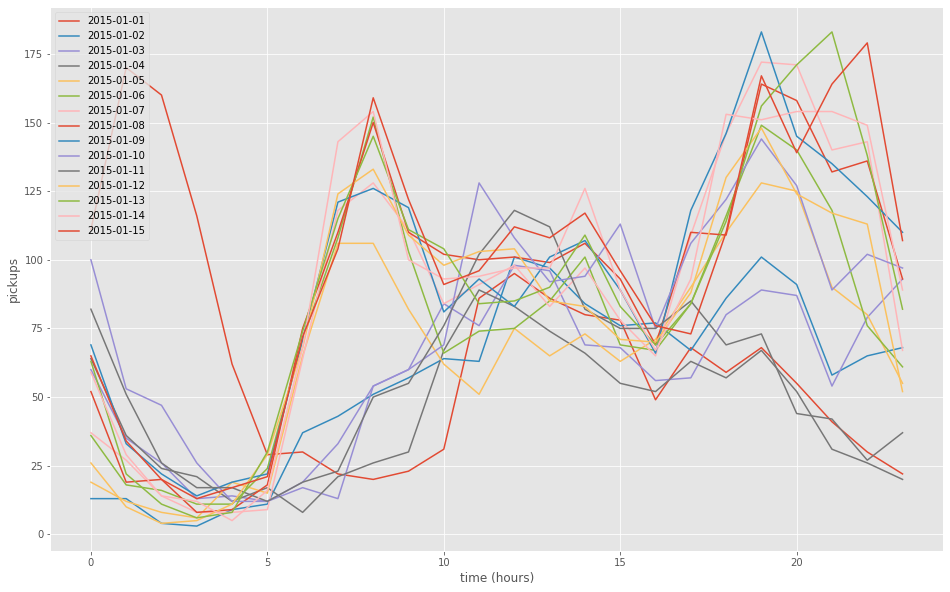

In [0]:
# visualize first 15 days of January 2015
dates = []
for day in range(1,16):   # we will search for days 1-15
    date = "2015-01-%.2d" % (day,)
    dates.append(date)
    plt.plot(df[df.date == date]["pickups"].values)   # select lines with corresponding date
plt.xlabel("time (hours)")
plt.ylabel("pickups")
plt.legend(dates);

We will now preprocess the dataset. Particularly, we will filter the data to keep only data from 2015, and we will also extract some relevant features from the dates (e.g. day of the week and hour of the day).

In [0]:
# convert datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d")

# filter: use only data from 2015
df = df[df.datetime.dt.year == 2015]

# add column with day of week (dow) and time of day (tod)
df["dow"] = df["datetime"].dt.weekday
df["tod"] = df["datetime"].dt.hour

df.head()  #let's see how the dataframe looks like now (notice new columns!)

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder,dow,tod
52584,2015-01-01 00:00:00,111,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,0
52585,2015-01-01 01:00:00,170,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,1
52586,2015-01-01 02:00:00,160,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,2
52587,2015-01-01 03:00:00,116,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,3
52588,2015-01-01 04:00:00,62,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,4


We wish to model the number of taxi pickups in the Wall Street area as a function of features such as the day of the week, time of the day and weather condtitions. 




However, the number of pickups is clearly not a linear function of these variables directly! For example, for time of the day - a discrete variable ranging from 0 to 23 - there's no reason to believe pickups to be proportional to the hour number! 

In order to allow for non-linear relationships, we shall consider a 1-of-K encoding of the day of week and time of day variables.

The Pandas method "get_dummies" exists just for that!

In [0]:
# a short demo of the one_of_K_enc function
enc=np.array(pd.get_dummies(df["tod"]))
print(enc.shape)
print(enc[:50,:]) # first 50 rows of tod. Notice that ech row has 24 numbers (1 one and 23 zeros) 

(8760, 24)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


So, let's do it for the two variables:

In [0]:
# prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
print(X_time.shape)

(8760, 31)


In [0]:
# prepare matrix with weather features
X_weather = df[["min_temp","max_temp","wind_speed","wind_gust",
                "visibility","pressure","precipitation","snow_depth",
                "fog","rain_drizzle","snow_ice"]].values
X_weather = df[["min_temp","snow_depth","precipitation"]].values
print(X_weather.shape)

In [0]:
# create matrix with time and weather features
X = np.concatenate([X_time, X_weather], axis=1)
print(X.shape)

# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

(8760, 34)


In [0]:
# prepare vector of target taxi pickups
y = df["pickups"].values

# standardize pickups
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
print(y.shape)

We now have all our data prepared and standardized. Note that it is often very important to have your data properly standardized (can you think of potential problems if your data is not standardized?).

The X matrix now contain all the input data for the model, and the y vector contains all the corresponding targets (number of taxi pickups).

The next step is to split our data into a train and test set. Alternatively, we could have used something like cross-validation, but for the sake of simplicity, a train/test split will do just fine for this example.

In [0]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_time_train = X_time[ix_train,:]
X_time_test = X_time[ix_test,:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 5781
num test: 2979


A crucial step in developing a experimental setup in machine learning is establishing how to access the quality of the models that we learn. For this purpose, we developed a funciton which already constains a series of popular metrics for evaluating the quality of the predictions of a regression model (continuous output variables!).

In [0]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

Just for the sake of comparision (and for fun!), lets run linear regression (or Ridge regression) from the popular sklearn package.

In [0]:
#regr = linear_model.LinearRegression()
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.803
MAE: 19.323
RMSE: 25.906
R2: 0.644


### STAN: Train on a small subset of the data

Time to implement Bayesian linear regression in STAN! (go back to the lecture slides, if necessary)

Note: since the input matrix X does not include a column with all 1's, we need to model the intercept term explicitly! We therefore shall include a alpha variable (the intercept) in the model for this purpose. The likelihood of the model is then as follows:

$y_n \sim \mathcal{N}(\alpha + \boldsymbol\beta^T \textbf{x}_n , \sigma^2)$

Can you implement the full model in STAN?

In [0]:
# define Stan model
model_definition = """
data {
    int<lower=0> N; // number of data items
    int<lower=0> D; // number of predictors
    matrix[N,D] x;  // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real alpha;             // intercept
    vector[D] beta;         // coefficients for predictors
    real<lower=0> sigma;    // error scale
} 
model {
    alpha ~ normal(0,10);                        // prior on the intercept
    sigma ~ cauchy(0,10);                        // prior on the variance
    for (d in 1:D)
        beta[d] ~ normal(0,1);             // prior on the coefficients
    y ~ normal(alpha + x * beta, sigma);   // likelihood
}
"""

We begin by doing inference on the model using MCMC (NUTS) and using only a small subsample of the dataset.

In [0]:
# prepare data for Stan model
X_train_small = X_train[:100,:]
y_train_small = y_train[:100]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'x': X_train_small, 'y': y_train_small}

Please run the above model, with the corresponding data

In [0]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.sampling(thin=100, data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1511d20bf91ff9ca54ff2adc5ccd233 NOW.


Inference for Stan model: anon_model_b1511d20bf91ff9ca54ff2adc5ccd233.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     -0.01    0.03   0.22   -0.4  -0.18-3.9e-3   0.15   0.43     53   0.87
beta[1]    -0.1    0.06   0.35  -0.71  -0.33  -0.08    0.2   0.46     33   1.05
beta[2]    0.05    0.07   0.38  -0.62  -0.23   0.08   0.33   0.67     29   0.98
beta[3]    0.07    0.06   0.35  -0.62  -0.07   0.09   0.32   0.66     31   1.08
beta[4]    0.22    0.05   0.39  -0.51  -0.07   0.34   0.56   0.77     59   0.88
beta[5]    0.01    0.07   0.43  -0.74  -0.26   0.02   0.33   0.65     41   0.95
beta[6]    0.02    0.07   0.35  -0.63  -0.27   0.03   0.31   0.52     22    1.0
beta[7]   -0.22    0.07   0.38  -0.78  -0.57  -0.16   0.07   0.28     26   0.96
beta[8]   -0.17     nan   0.22  -0.54  -0.35  -0.13  -0.06   0.28    -72   0.84
beta[9]   -0.17

/Users/fmpr/stan/lib/python3.5/site-packages/pystan/misc.py:355: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


Plot the posterior distribution of all the latent variables in the model (alpha, betas and sigma).

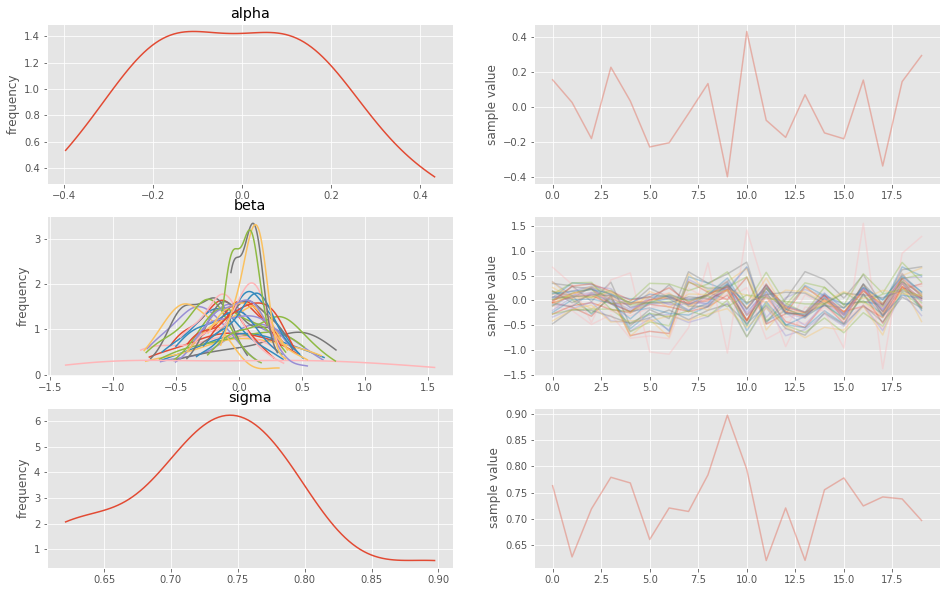

In [0]:
pl = fit.plot()

Given the posterior distributions over the variables alpha and beta, we can make predictions for the test set. In this case there are multiple ways to do this! Lets see...

First, recall that the output of STAN consists of samples from the posterior distribution of the latent variables ("parameters" block in the STAN program). We can use these samples to compute the mean (or mode!) of the posterior distribution over alpha and beta ($\hat{\alpha}$ and $\hat{\boldsymbol\beta}$, respectively), and then use that mean/mode to make predictions $\hat{y}$ as follows:

$\hat{y}_n = \hat{\alpha} + \hat{\boldsymbol\beta}^T \textbf{x}_n$

Can you create a vector called "y_hat" with the predictions for the test set?

In [0]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
print(samples["alpha"].shape)
print(samples["beta"].shape)

beta_hat=np.array([np.mean(b) for b in samples["beta"].T])
alpha_hat=np.mean(samples["alpha"])

y_hat = alpha_hat+np.dot(X_test,beta_hat)

(20,)
(20, 34)


In [0]:
y_hat

array([ 0.35437193, -1.49507557, -1.17998262, ...,  0.74171854,
        0.9639631 ,  0.67713992])

Since we standardized the target variable $y$ (number of taxi pickups) before feeding it to the STAN model, we need to convert the predictions back to original scale before evaluating their quality:

In [0]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.717
MAE: 23.618
RMSE: 30.790
R2: 0.498


What we just did for making predictions seems a bit wasteful. STAN just computed for us the (whole!) posterior distribution for alpha and beta, and we completely ignored it by looking at its mean (or mode) and using that to make predictions. Furthermore, why use the mean instead of the mode (or vice-versa)? For sure there must be a better way...

Indeed, the proper Bayesian way of making predictions for our Bayesian linear regression model is to follow the rules of probability. Namely, our goal in prediction is to use the posterior over $\alpha$ and $\boldsymbol\beta$ given the observed data, $p(\alpha | \textbf{y}, \textbf{X})$ and $p(\boldsymbol\beta | \textbf{y}, \textbf{X})$ respectively, to compute the posterior distribution of the target variable $y_*$ for a new input vector $\textbf{x}_*$ as follows:

$p(y_* | \textbf{x}_*, \textbf{y}, \textbf{X}, \sigma) = \int \int \mathcal{N}(y_* | \alpha + \boldsymbol\beta^T \textbf{x}_*, \sigma^2) \, p(\alpha | \textbf{y}, \textbf{X}) \, p(\boldsymbol\beta | \textbf{y}, \textbf{X}) \, d\alpha \, d\boldsymbol\beta$

Notice that we are integrating (or marginalizing) over all values of $\alpha$ and $\boldsymbol\beta$. We can think of this as averaging over the values of $\alpha$ and $\boldsymbol\beta$ according to their posterior distributions.

Since STAN outputs a set of $S$ samples from the posteriors, $\{\alpha^{(s)}, \boldsymbol\beta^{(s)}\}_{s=1}^S$, we can easily use them to approximate the expected value of $y_*$ as follows:

$\mathbb{E}[y_*] \approx \frac{1}{S} \sum_{s=1}^S \alpha^{(s)} + (\boldsymbol\beta^{(s)})^T \textbf{x}_*$

So lets do that!

In [0]:
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

We can evaluate the (new) predictions:

In [0]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.717
MAE: 23.618
RMSE: 30.790
R2: 0.498


Did you get similar error values as before? Probably they didn't change much in this case, because the posteriors of $\alpha$ and $\boldsymbol\beta$ look very Gaussian and also because our likelihood is Gaussian too! But if the posteriors were skewed or multimodal, then this approximation to the Bayesian integral would likely yield quite different results from the ones obtained by using the mean or the mode of the posterior distribution. Therefore, this is something important to be aware of!

### STAN: Train on a slightly larger subset of the data

We will now do inference on a slightly larget subset of the data, and see what happens...

In [0]:
# prepare data for Stan model
X_train_small = X_train[:1000,:]
y_train_small = y_train[:1000]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'x': X_train_small, 'y': y_train_small}

In [0]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.sampling(data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1511d20bf91ff9ca54ff2adc5ccd233 NOW.


Inference for Stan model: anon_model_b1511d20bf91ff9ca54ff2adc5ccd233.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     -0.04  5.1e-4   0.02  -0.07  -0.05  -0.04  -0.02 1.2e-3   1495    1.0
beta[1]   -0.04    0.02   0.37  -0.77   -0.3  -0.04   0.22   0.68    553    1.0
beta[2]    0.03    0.02   0.38  -0.71  -0.23   0.03   0.29   0.77    551    1.0
beta[3]    0.08    0.02   0.38  -0.65  -0.18   0.08   0.34   0.82    550    1.0
beta[4]    0.06    0.02   0.38  -0.68   -0.2   0.06   0.32    0.8    551    1.0
beta[5]    0.07    0.02   0.38  -0.66  -0.19   0.07   0.33   0.79    551    1.0
beta[6]    0.03    0.02   0.38  -0.69  -0.23   0.03    0.3   0.77    555    1.0
beta[7]   -0.22    0.02   0.38  -0.95  -0.48  -0.22   0.05    0.5    551    1.0
beta[8]   -0.06    0.01   0.22  -0.47  -0.21  -0.07   0.09   0.38    255   1.01
beta[9]   -0.

Plot the posterior distribution of all the latent variables in the model (alpha, betas and sigma).

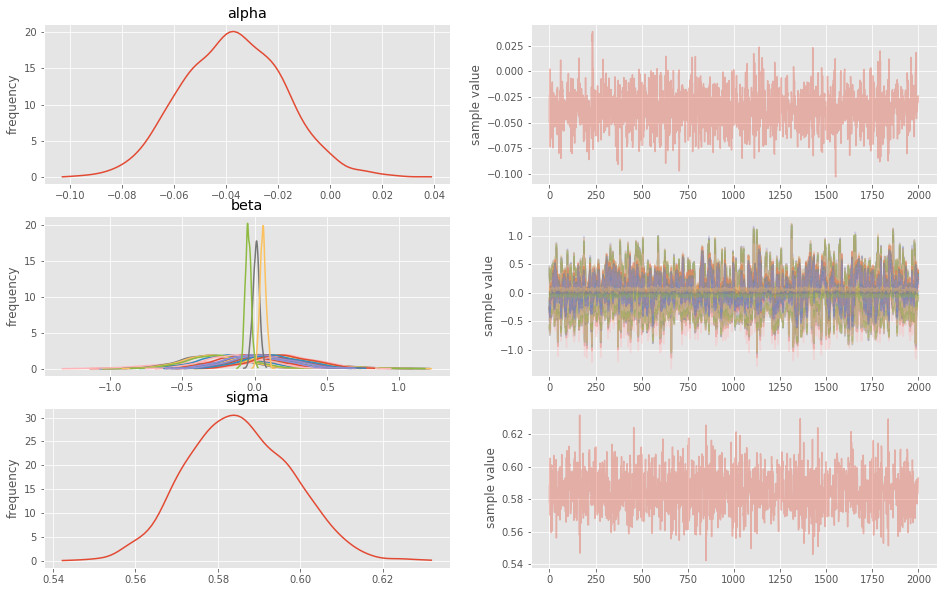

In [0]:
pl = fit.plot();

Compare the new posterior distributions with the ones obtained by using only 100 data points from the dataset (above). Be careful with the scales of the plots...

Notice how the model is now much more confident about the posterior distribution of the latent variables in the model (narrower distributions; lower uncertainty in the estimates). This makes sense! The more data we observe, the more confident we become about our estimates.

Now, lets extract the samples from STAN and make predictions for the test set

In [0]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

And lets check the error statistics...

In [0]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.794
MAE: 19.727
RMSE: 26.553
R2: 0.626


Better, right? But this took quite longer to run, and in this case didn't necessarily beat "sklearn"...

MCMC methods have great properties, namely the fact that in the limit of infinite computation time they will converge to the true posterior distribution. However, they often have difficulty scaling to larger datasets. 

### STAN: Train on full dataset using ADVI

ADVI on the other hand is much more scalable. Let us now try to use ADVI to perform inference in our model.

In [0]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'x': X_train, 'y': y_train}

In [0]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1511d20bf91ff9ca54ff2adc5ccd233 NOW.


CPU times: user 13.9 s, sys: 259 ms, total: 14.2 s
Wall time: 56.9 s


Lets look at the posterior distribution. This is where the "pystan_utils" package that we developed will be useful...

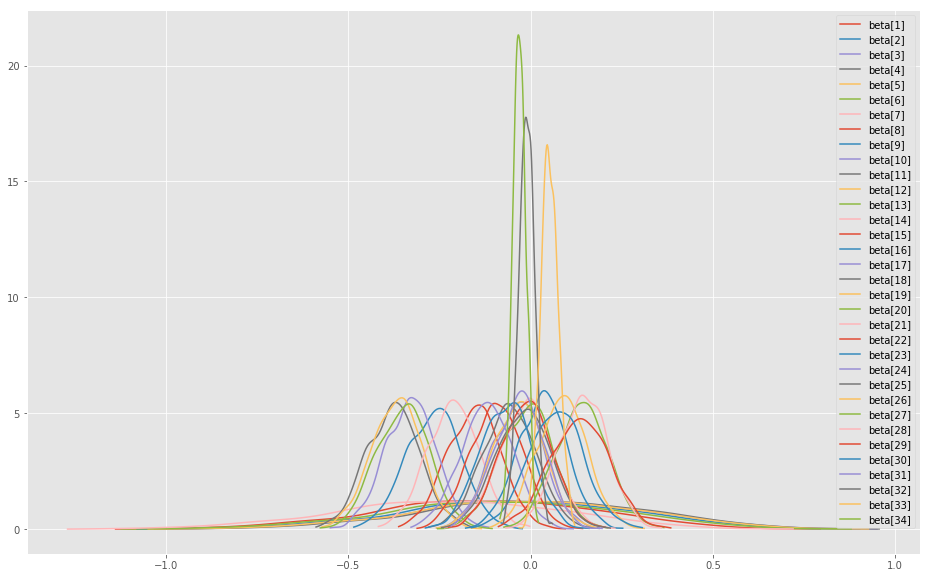

In [0]:
pystan_utils.vb_plot_variables(fit, "beta")

We can also use pystan_utils to extract the mean values of the posteriors:

In [0]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="real")
print("alpha:", alpha)

beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")
print("beta:", beta)


alpha: -0.004536950156822813
beta: [-0.13626668 -0.05125764 -0.01980351 -0.00167323 -0.0216517  -0.08958646
 -0.23792096 -0.15717437 -0.26826602 -0.33088375 -0.37727368 -0.36988382
 -0.352008   -0.2139543  -0.09545579  0.03160239 -0.0381963  -0.05958526
 -0.03589838 -0.01319942 -0.01312201 -0.01448022 -0.06982286 -0.1217818
 -0.02204695  0.08494954  0.13771625  0.14160317  0.13182538  0.0673858
 -0.03396732 -0.01065079  0.05135581 -0.03171427]


We also made a more direct way (but more verbose) option for you

In [0]:
pystan_utils.report(fit, 'alpha')
pystan_utils.report(fit, 'beta')

alpha = -0.004536950156822813
beta[1] = -0.13626668155545338
beta[2] = -0.05125764487473076
beta[3] = -0.019803510578520967
beta[4] = -0.0016732320401627839
beta[5] = -0.021651702337807152
beta[6] = -0.08958646153584927
beta[7] = -0.23792096398025872
beta[8] = -0.15717437191073874
beta[9] = -0.26826601701139047
beta[10] = -0.33088375393362873
beta[11] = -0.37727368306088943
beta[12] = -0.36988382182350693
beta[13] = -0.35200799846832376
beta[14] = -0.21395429974458124
beta[15] = -0.09545578859448252
beta[16] = 0.03160239459055101
beta[17] = -0.03819629717433297
beta[18] = -0.05958525828695271
beta[19] = -0.035898378213685495
beta[20] = -0.01319941567917595
beta[21] = -0.013122008010879186
beta[22] = -0.014480224449769449
beta[23] = -0.06982285802242016
beta[24] = -0.12178179799049524
beta[25] = -0.022046949252035035
beta[26] = 0.08494954283281256
beta[27] = 0.13771625263848516
beta[28] = 0.1416031739608061
beta[29] = 0.13182538238286798
beta[30] = 0.06738580031744952
beta[31] = -0.0339

Using the estimated values, we can make predictions for the test set:

In [0]:
y_hat = alpha + np.dot(X_test, beta)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.804
MAE: 19.292
RMSE: 25.879
R2: 0.645


If we now compare these results with the ones from the "sklearn" package, we can see that we are now doing slightly better...

## 2.2. STAN: Poisson regression

In our previous STAN model, we assumed that the target variable $y$ is Gaussian distributed. However, this might not be the most reasonable choice. Where are modeling the number of taxi pickups (counts!). Perhaps a much more reasonable likelihood is the Poisson distribution:

$y_n \sim \mbox{Poisson}(\exp(\alpha + \boldsymbol\beta^T \textbf{x}_n))$

Notice that we included a log link function to ensure that the rate of the Poisson (the parameter of the Poisson) is non-negative, as required by the definition of the Poisson.

Lets implement this model in STAN!

Hint: STAN offers a more numerically stable version of a Poisson distribution with a log link function (when compared to a naive implementation). Check out the function "poisson_log()" in the documentation!

In [0]:
# define Stan model
model_definition = """
data {
    int<lower=0> N; // number of data items
    int<lower=0> D; // number of predictors
    matrix[N,D] x;  // predictor matrix
    int y[N];       // outcome vector
}
parameters {
    real alpha;             // intercept
    vector[D] beta;         // coefficients for predictors
} 
model {
    alpha ~ normal(0,10);                // prior on the intercept
    for (d in 1:D)
        beta[d] ~ normal(0,1);           // prior on the coefficients
    y ~ poisson_log(alpha + x * beta);   // likelihood
}
"""

Prepare data for STAN and run inference:

In [0]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'x': X_train, 'y': (y_train * y_std + y_mean).astype(np.int)} # y must be original counts

In [0]:
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3dd48872bb43deb7dffeaf0d407456bf NOW.


Extract results and compute error statistics:

In [0]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="real")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")
y_hat = np.exp(alpha + np.dot(X_test, beta))

# convert back to the original scale
preds = y_hat # no need for this one
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.823
MAE: 18.128
RMSE: 24.711
R2: 0.676


Now this is a significative improvement!

By freeing us from predefined standard machine learning algorithms through the use of probability theory, PGMs and approximate Bayesian inference (thanks to STAN, in this case), the model-based machine learning approach gives us the flexibility to develop machine learning models that are specifically tailored to our particular problems! In this case, we know that the target variables is a count (number of taxi pickups), and can revise our model accordingly, so that it encodes our knowledge of the domain.

## 2.3 STAN: Heteroscedastic regression

Ok, let us now assume again that the Gaussian likelihood was indeed the most appropriate choice. In many problems of interest, it is often the case that constant observation variance ($\sigma^2$) is too limiting or inadequate. We can relax this assumption by considering heteroscedastic models, in which the observation variance is assumed to be non-constant and dependent on any other variables. In this particular case, we shall assume that the observation variance is also linearly dependent on the inputs $\textbf{x}$. 

Lets implement this model in STAN (check the lecture slides, if necessary)!

In [0]:
# define Stan model
model_definition = """
data {
    int<lower=0> N; // number of data items
    int<lower=0> D; // number of predictors
    matrix[N,D] x;  // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real alpha;             // intercept
    vector[D] beta;         // coefficients for predictors
    real alpha2;             // intercept
    vector[D] beta2;         // coefficients for predictors
} 
model {
    alpha ~ normal(0,10);                        // prior on the intercept
    for (d in 1:D)
        beta[d] ~ normal(0,1);             // prior on the coefficients
    alpha2 ~ normal(0,1);                        // prior on the intercept
    for (d in 1:D)
        beta2[d] ~ normal(0,1);             // prior on the coefficients
    y ~ normal(alpha + x * beta, exp(alpha2 + x * beta2));   // likelihood
}
"""

Prepare data for STAN and run inference:

In [0]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'x': X_train, 'y': y_train}

In [0]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
#fit = sm.vb(data=data, iter=1000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)
fit = sm.sampling(data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f217807f27b6dc6ad9d56445c85f0e4 NOW.


CPU times: user 3.59 s, sys: 430 ms, total: 4.02 s
Wall time: 36min 27s


In [0]:
#
print(fit)

Inference for Stan model: anon_model_5f217807f27b6dc6ad9d56445c85f0e4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       0.07  2.3e-4 7.9e-3   0.06   0.07   0.07   0.08   0.09   1171    1.0
beta[1]    -0.03    0.02   0.38  -0.82  -0.28  -0.02   0.21   0.75    361   1.01
beta[2]   3.2e-3    0.02   0.38  -0.79  -0.25   0.01   0.25   0.78    361   1.01
beta[3]     0.02    0.02   0.38  -0.78  -0.23   0.02   0.26   0.79    361   1.01
beta[4]     0.03    0.02   0.38  -0.77  -0.22   0.04   0.28   0.81    361   1.01
beta[5]     0.05    0.02   0.38  -0.74   -0.2   0.06    0.3   0.82    362   1.01
beta[6]     0.07    0.02   0.38  -0.72  -0.18   0.08   0.31   0.84    361   1.01
beta[7]     0.03    0.02   0.38  -0.77  -0.22   0.03   0.27    0.8    361   1.01
beta[8]    -0.13    0.02   0.19  -0.51  -0.26  -0.12 3.1e-3   0.24    117   1.03
bet

Extract results and compute error statistics:

In [0]:
#
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.766
MAE: 19.604
RMSE: 28.561
R2: 0.568


In this case, probably you weren't able to improve the results. This is because for this particular problem - taxi pickups - modelling the observation noise as dependent on the inputs $\textbf{x}$ does not make a big difference. But for many problems it does! Think of problems in finance or many problems related to road traffic...

Although the mean predictions of the heteroscedastic model are not better than before, we can now estimate the non-constant observation uncertainty for the data points in the dataset.

In [0]:
sigma_hat = np.mean(np.exp(samples["alpha2"].T + np.dot(X_test, samples["beta2"].T)), axis=1)

In [0]:
print(sigma_hat)

[0.86401603 0.11617182 0.1904024  ... 0.3266371  0.85322687 0.99864962]


Notice how it changes over time. We can use these values to estimate prediction intervals (e.g. 95% prediction intervals) that are time-varying. Can you think of real-world problems where this information would be useful?